In [1]:
import numpy as np
import time
import discretize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

from pymatsolver import Pardiso as Solver
from SimPEG import maps, data
from SimPEG.meta import MultiprocessingMetaSimulation
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
from SimPEG.electromagnetics import natural_source as nsem
from discretize.utils import mkvc, ndgrid, active_from_xyz
from SimPEG.utils import plot2Ddata
%autosave 0

Autosave disabled


In [2]:
# Load the topo
dir = "../data/field/"
topo = np.loadtxt(dir + "topo.xyz")

In [3]:
# Import data as a list and rearrange the data based on frequencies
data_by_freq = {}

with open(dir + "ztem_data.dat", 'r') as file:
    # Iterate over each line in the file
    for line in file:
        # If the line starts with "frequency", update the current frequency

        if line.startswith("FREQUENCY"):
            current_freq = int(line.split()[1])  # Assuming the frequency is an integer
            data_by_freq[current_freq] = []
            n_recv = int(next(file).split()[1])  # Get the number of rows for the current frequency
            for _ in range(n_recv):  # Read the next n_recv lines
                row = [float(x) for x in next(file).split()]
                row_without_zeros = [x for x in row if x != 0.0]  # Ignore columns with zeros
                row_without_zeros.append(current_freq)  # Add the frequency as a new column
                data_by_freq[current_freq].append(row_without_zeros)

# Convert list to array organized as (x,y,z, Tzx_real,Tzx_imag, Tzy_real,Tzy_imag, freq)
ztem_data = np.concatenate([np.array(data_by_freq[freq]) for freq in data_by_freq])
# Define rotation matrix and rotate the data
theta_1 = np.radians(45)  # Convert angle to radians
theta_2 = np.radians(45)  # Convert angle to radians
rotation_matrix_data = np.array([[np.cos(theta_1), - np.sin(theta_1)], [ np.sin(theta_1), np.cos(theta_1)]])
rotation_matrix_topo = np.array([[np.cos(theta_2), - np.sin(theta_2)], [ np.sin(theta_2), np.cos(theta_2)]])


# Apply the rotation matrix to each point
rotated_xy_data = np.dot(ztem_data[:,:2], rotation_matrix_data.T)
rotated_xy_topo = np.dot(topo[:,:2], rotation_matrix_topo.T)

# Update the x and y coordinates in the data
ztem_data[:,0] = rotated_xy_data[:,0]
ztem_data[:,1] = rotated_xy_data[:,1]

#Update the x and y coordinates in the topo
topo[:,0] = rotated_xy_topo[:,0]
topo[:,1] = rotated_xy_topo[:,1]

def decimate_data(data, threshold, extent_data, outside_threshold):
    decimated_data = [data[0]]  # Start with the first point

    min_extent = np.min(extent_data, axis=0)
    max_extent = np.max(extent_data, axis=0)

    for point in data[1:]:
        last_point = decimated_data[-1]
        distance = np.sqrt((point[0] - last_point[0])**2 + (point[1] - last_point[1])**2 + (point[2] - last_point[2])**2)

        if (point[0] < min_extent[0] or point[0] > max_extent[0] or
            point[1] < min_extent[1] or point[1] > max_extent[1] or
            point[2] < min_extent[2] or point[2] > max_extent[2]):
            current_threshold = outside_threshold
        else:
            current_threshold = threshold

        if distance > current_threshold:
            decimated_data.append(point)

    return np.array(decimated_data)

# Use the function
ztem_data_deci = decimate_data(ztem_data, threshold=800, extent_data=ztem_data, outside_threshold=800)
topo_deci = decimate_data(topo, threshold=400, extent_data=ztem_data, outside_threshold=800)

def rx_locs(data, freq):
    rx_subset = data[data[:,-1] == freq]
    rx_x = rx_subset[:, 0]
    rx_y = rx_subset[:, 1]
    rx_z = rx_subset[:, 2]
    receiver_locations = np.c_[rx_x,rx_y,rx_z]
    return receiver_locations
receiver_locations = rx_locs(ztem_data_deci,30)

In [4]:
def closest_value(mesh, target_value, axis):
    """
    Find the value in the specified axis of the mesh that is closest to a target value.
    
    Parameters
    ----------
    mesh : object
        The mesh object with attributes 'nodes_x', 'nodes_y', and 'nodes_z'.
    target_value : float
        The target value to find the closest value to.
    axis : str
        The axis to search for the closest value. Should be 'x', 'y', or 'z'.

    Returns
    -------
    float
        The value in the specified axis of the mesh that is closest to the target value.

    Examples
    --------
    >>> mesh = Mesh(nodes_x=[1, 2, 3], nodes_y=[4, 5, 6], nodes_z=[7, 8, 9])
    >>> closest_value(mesh, 8.1, 'z')
    8
    """
    nodes = getattr(mesh, f'nodes_{axis}')
    differences = np.abs(nodes - target_value)
    closest_index = np.argmin(differences)
    closest_value = nodes[closest_index]
    return closest_value

In [12]:
# Define rotation matrix and rotate the data
theta_3 = np.radians(-45)  # Convert angle to radians

rotation_matrix_model = np.array([[np.cos(theta_3), - np.sin(theta_3)], [ np.sin(theta_3), np.cos(theta_3)]])




In [7]:
mesh = discretize.TreeMesh.read_UBC("../inv_models/field/depth_weighting/ztem_field_deci_v3.msh")
mesh


OcTreeMesh: 19.16% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       256            ---------------------------   --------------------
  4   :      3553         x: -2201060.861 ,-2160100.861      320.0   ,   2560.0  
  5   :      9886         y: 2930265.4769 ,2971225.4769      320.0   ,   2560.0  
  6   :      86736        z: -1687.0466000000001,  3432.9534       160.0   ,   1280.0  
-----------------------
Total :     100431

In [8]:
sig_back = 5e-3
sig_air = 1e-6


In [81]:
#dir = "git/ztem_simpeg/data/field/"InversionModel-2024-04-10-19-04.npy
load_inv_depth_wt = np.load("../inv_models/field/depth_weighting/005-InversionModel-2024-04-26-13-30.npy")
mesh_depth_wt = discretize.TreeMesh.read_UBC("../inv_models/field/depth_weighting/ztem_field_deci_v2_depth_wt.msh")


load_inv_no_depth_wt = np.load("../inv_models/field/no_depth_weighting/005-InversionModel-2024-04-26-02-39.npy")
mesh_no_depth_wt = discretize.TreeMesh.read_UBC("../inv_models/field/no_depth_weighting/ztem_field_deci_v2_no_depth_wt.msh")



In [100]:
def plot_model_slice(load_inv, mesh, receiver_locations, slice_axis='x'):
    #Define active indices below topography
    active_inds = active_from_xyz(mesh, topo_deci, 'N')

    model = sig_air * np.ones(mesh.nC)
    model[active_inds] = sig_back
    halfspace = model.copy()
    actMap = maps.InjectActiveCells(mesh=mesh, indActive=active_inds, valInactive=np.log(sig_air))
    plot_map = maps.ExpMap(mesh) * actMap
    mopt_rec = plot_map * load_inv
    fig = plt.figure(figsize=(12, 6))

    xlim = [np.min(receiver_locations[:, 0]), np.max(receiver_locations[:, 0])]
    ylim = [np.min(receiver_locations[:, 1]), np.max(receiver_locations[:, 1])]
    zlim = [-1500, 2000]

    plot_ind = np.where(getattr(mesh, f'nodes_{slice_axis}') == closest_value(mesh, -2181220, slice_axis))[0][0]

    ax1 = fig.add_subplot(121)
    out = mesh.plot_slice(np.log10(mopt_rec), normal=slice_axis.upper(), ax=ax1, ind=plot_ind, grid=True, pcolor_opts={"vmin":np.log10(1e-3), "vmax":np.log10(0.1)})
    cb = plt.colorbar(out[0], orientation="vertical")
    cb.set_label("Conductivity (S/m)")

    ax1.set_title(f"Model slice at {slice_axis} = {getattr(mesh, f'nodes_{slice_axis}')[int(plot_ind)]}m")

    if slice_axis == 'y' or slice_axis == 'x':
        ax1.set_ylim(zlim)
        if slice_axis == 'y':
            ax1.set_xlim(xlim)
            ax1.set_xlabel('x (m)')
        else:
            ax1.set_xlim(ylim)
            ax1.set_xlabel('y (m)')
        ax1.set_ylabel('Z (m)')
    else:
        ax1.set_ylim(ylim)
        ax1.set_xlim(xlim)
        ax1.set_xlabel('x (m)')
        ax1.set_ylabel('y (m)')

    plt.show()

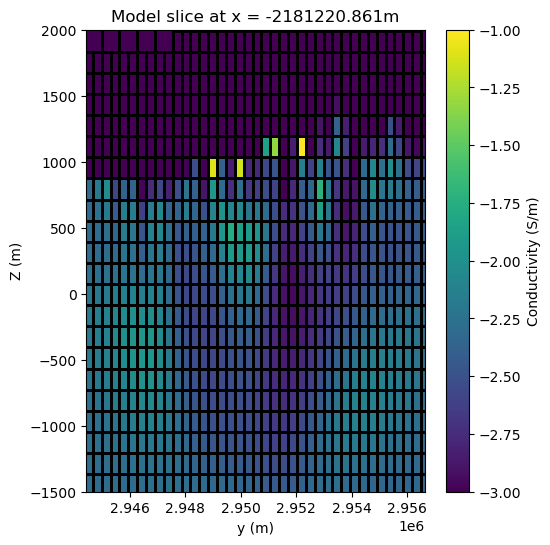

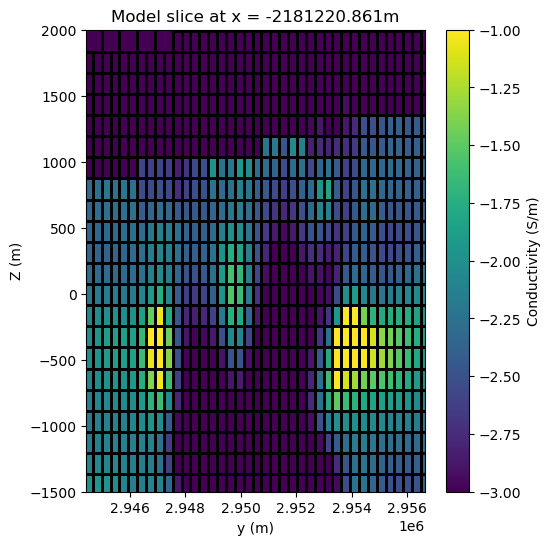

In [101]:
plot_model_slice(load_inv_no_depth_wt, mesh_no_depth_wt, receiver_locations, slice_axis='x')
plot_model_slice(load_inv_depth_wt, mesh_depth_wt, receiver_locations, slice_axis='x')

In [53]:
load_inv_giftools = mesh.read_model_UBC(r"C:\Users\parth\OneDrive_UBC\Masters\2023-2024\EOSC_556B_Lindsey_Inv\Project\comprehensive_workflow_mt_ztem\mt_ztem_workflow_results\inv_ztem_002_smoothest\inv_006.con")
mesh_giftools = mesh.read_UBC(r"C:\Users\parth\OneDrive_UBC\Masters\2023-2024\EOSC_556B_Lindsey_Inv\Project\comprehensive_workflow_mt_ztem\mt_ztem_workflow_results\inv_ztem_002_smoothest\ztem_octree_mesh.msh")

In [43]:
active_inds = np.loadtxt(r"C:\Users\parth\OneDrive_UBC\Masters\2023-2024\EOSC_556B_Lindsey_Inv\Project\comprehensive_workflow_mt_ztem\mt_ztem_workflow_results\inv_ztem_002_smoothest\ztem_active_cells.act",)
active_inds = (active_inds != 0)

In [57]:
load_inv_giftools.shape

(206271,)

In [44]:
mesh = mesh_giftools
load_inv = load_inv_giftools
slice_axis = 'x'

model = sig_air * np.ones(mesh.nC)
model[active_inds] = sig_back
halfspace = model.copy()
actMap = maps.InjectActiveCells(mesh=mesh, indActive=active_inds, valInactive=np.log(sig_air))
plot_map = maps.ExpMap(mesh) * actMap
mopt_rec = plot_map * load_inv
fig = plt.figure(figsize=(12, 6))

#xlim = [np.min(receiver_locations[:, 0]), np.max(receiver_locations[:, 0])]
#ylim = [np.min(receiver_locations[:, 1]), np.max(receiver_locations[:, 1])]
zlim = [-2000, 2000]

plot_ind = np.where(getattr(mesh, f'nodes_{slice_axis}') == closest_value(mesh, -2181220, slice_axis))[0][0]

ax1 = fig.add_subplot(121)
out = mesh.plot_slice(np.log10(mopt_rec), normal=slice_axis.upper(), ax=ax1, ind=plot_ind, grid=True, pcolor_opts={"vmin":np.log10(1e-4), "vmax":np.log10(0.1)})
cb = plt.colorbar(out[0], orientation="vertical")

ax1.set_title(f"Model slice at {slice_axis} = {getattr(mesh, f'nodes_{slice_axis}')[int(plot_ind)]}m")

if slice_axis == 'y' or slice_axis == 'x':
    #ax1.set_ylim(zlim)
    if slice_axis == 'y':
        #ax1.set_xlim(xlim)
        ax1.set_xlabel('x (m)')
    else:
        #ax1.set_xlim(ylim)
        ax1.set_xlabel('y (m)')
    ax1.set_ylabel('Z (m)')
else:
    #ax1.set_ylim(ylim)
    #ax1.set_xlim(xlim)
    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')

plt.show()

ValueError: Dimension mismatch in ComboMap[ExpMap(206271,206271) * InjectActiveCells(206271,140766)](206271,140766) and np.ndarray(100431,).